<a href="https://colab.research.google.com/github/openjamoses/Model-conversion/blob/main/onnx_zoo_conversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip uninstall tensorflow
!pip uninstall onnx

Uninstalling tensorflow-2.5.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.5.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.5.0


In [ ]:
!pip install tensorflow
!pip install onnx==1.8.1
!pip install onnx_tf

In [4]:
#%tensorflow_version 1.x
from tensorflow import keras
import tensorflow as tf
print(tf.__version__)

2.5.0


In [5]:
#Import needed packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from onnx_tf.backend import prepare

In [6]:
from google.colab import drive
drive.mount('/content/drive')
path_output = "/content/drive/MyDrive/Colab Notebooks/models/torch/save/"

Mounted at /content/drive


In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
 
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [8]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [9]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
 
    test_loss /= len(test_loader.dataset)
 
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [10]:
#def main():
device =  "cpu"
train_loader = torch.utils.data.DataLoader(
datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(
datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
batch_size=1000, shuffle=True)
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
 
for epoch in range(0, 5): 
  train(model, device, train_loader, optimizer, epoch) 
  test(model, device, test_loader)
torch.save(model.state_dict(),path_output+"model.pt")


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.310008
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.401208
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.319989
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.159391
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.131457
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.143643
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.217413
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.112390
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.067025
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.041402

Test set: Average loss: 0.0956, Accuracy: 9714/10000 (97%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.063342
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.034307
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.131638
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.085060
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.020943
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.088812
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.015732
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.025499
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.053336
T

In [ ]:
!pip install pytorch2keras
#!pip install onnx==1.8.1

In [12]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [13]:
path = '/content/drive/MyDrive/Colab Notebooks/'
#hymenoptera_data.zip

In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/hymenoptera_data.zip' -d '/content'

In [16]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


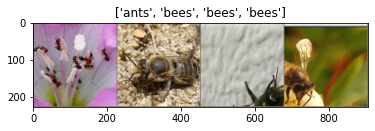

In [17]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [18]:
import csv
import pandas as pd
from datetime import datetime

In [19]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    date = datetime.today().strftime('%Y-%m-%d-%H:%M:%S')

    data_file = open('/content/experiment_train_{}.csv'.format(date), mode='w+', newline='', encoding='utf-8')
    data_writer = csv.writer(data_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    data_writer.writerow(['Model','type', 'Dataset', 'Epoch', 'criterion', 'optimizer', 'scheduler','Train_loss', 'Train_acc', "val_loss", "Val_acc", 'time','Elapse_time','date'])


    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        since_1 = time.time()

        # Each epoch has a training and validation phase
        #data_writer.writerow(['Model','type', 'Dataset', 'Train_loss', 'Train_acc', "val_loss", "Val_acc"])
        rows = [model, 'pytorch','hymenoptera_data','{}/{}'.format(epoch, num_epochs - 1) ,criterion, optimizer, scheduler]
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            rows.append(phase)
            rows.append('Loss: {:.4f}'.format(epoch_loss))
            rows.append('Acc: {:.4f}'.format(epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        time_elapsed_1 = time.time() - since_1
        print()
        rows.append(time.time())
        rows.append('{:.0f}m {:.0f}s'.format(time_elapsed_1 // 60, time_elapsed_1 % 60))
        data_writer.writerow(rows)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    data_writer.writerow(['','', '', '', '', '', "", 'Best val Acc: {:4f}'.format(best_acc), time.time(),'Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60),''])

    data_file.close()
    return model

In [20]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [21]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


In [22]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5514 Acc: 0.7582
val Loss: 0.3222 Acc: 0.8889

Epoch 1/4
----------
train Loss: 0.4795 Acc: 0.7951
val Loss: 0.5027 Acc: 0.7974

Epoch 2/4
----------
train Loss: 0.4819 Acc: 0.8156
val Loss: 0.2879 Acc: 0.8758

Epoch 3/4
----------
train Loss: 0.4703 Acc: 0.7828
val Loss: 0.1802 Acc: 0.9281

Epoch 4/4
----------
train Loss: 0.3770 Acc: 0.8443
val Loss: 0.2640 Acc: 0.9216

Training complete in 7m 3s
Best val Acc: 0.928105


In [23]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [24]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.7184 Acc: 0.5943
val Loss: 0.5149 Acc: 0.7712

Epoch 1/4
----------
train Loss: 0.5108 Acc: 0.7828
val Loss: 0.1919 Acc: 0.9346

Epoch 2/4
----------
train Loss: 0.4132 Acc: 0.8197
val Loss: 0.2196 Acc: 0.9346

Epoch 3/4
----------
train Loss: 0.4033 Acc: 0.8443
val Loss: 0.1784 Acc: 0.9542

Epoch 4/4
----------
train Loss: 0.4847 Acc: 0.7869
val Loss: 0.1742 Acc: 0.9412

Training complete in 3m 13s
Best val Acc: 0.954248


In [25]:
import numpy as np
import torch
from torch.autograd import Variable
from pytorch2keras.converter import pytorch_to_keras
import torchvision.models as models

In [110]:
input_np = np.random.uniform(0, 1, (1, 3, 224, 224))
input_var = Variable(torch.FloatTensor(input_np))
k_model_model_conv = pytorch_to_keras(model_conv, input_var, [(3, 224, 224,)], verbose=True, change_ordering=True)

INFO:pytorch2keras:Converter is called.
DEBUG:pytorch2keras:Input_names:
DEBUG:pytorch2keras:['input_0']
DEBUG:pytorch2keras:Output_names:
DEBUG:pytorch2keras:['output_0']
INFO:onnx2keras:Converter is called.
DEBUG:onnx2keras:List input shapes:
DEBUG:onnx2keras:[(3, 224, 224)]
DEBUG:onnx2keras:List inputs:
DEBUG:onnx2keras:Input 0 -> input_0.
DEBUG:onnx2keras:List outputs:
DEBUG:onnx2keras:Output 0 -> output_0.
DEBUG:onnx2keras:Gathering weights to dictionary.
DEBUG:onnx2keras:Found weight fc.weight with shape (2, 512).
DEBUG:onnx2keras:Found weight fc.bias with shape (2,).
DEBUG:onnx2keras:Found weight 193 with shape (64, 3, 7, 7).
DEBUG:onnx2keras:Found weight 194 with shape (64,).
DEBUG:onnx2keras:Found weight 196 with shape (64, 64, 3, 3).
DEBUG:onnx2keras:Found weight 197 with shape (64,).
DEBUG:onnx2keras:Found weight 199 with shape (64, 64, 3, 3).
DEBUG:onnx2keras:Found weight 200 with shape (64,).
DEBUG:onnx2keras:Found weight 202 with shape (64, 64, 3, 3).
DEBUG:onnx2keras:Fou

graph(%input_0 : Float(1, 3, 224, 224, strides=[150528, 50176, 224, 1], requires_grad=0, device=cpu),
      %fc.weight : Float(2, 512, strides=[512, 1], requires_grad=1, device=cpu),
      %fc.bias : Float(2, strides=[1], requires_grad=1, device=cpu),
      %193 : Float(64, 3, 7, 7, strides=[147, 49, 7, 1], requires_grad=0, device=cpu),
      %194 : Float(64, strides=[1], requires_grad=0, device=cpu),
      %196 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cpu),
      %197 : Float(64, strides=[1], requires_grad=0, device=cpu),
      %199 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cpu),
      %200 : Float(64, strides=[1], requires_grad=0, device=cpu),
      %202 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cpu),
      %203 : Float(64, strides=[1], requires_grad=0, device=cpu),
      %205 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cpu),
      %206 : Float(64, strides=[1], requires_grad

DEBUG:onnx2keras:Found weight 239 with shape (512,).
DEBUG:onnx2keras:Found weight 241 with shape (512, 512, 3, 3).
DEBUG:onnx2keras:Found weight 242 with shape (512,).
DEBUG:onnx2keras:Found weight 244 with shape (512, 256, 1, 1).
DEBUG:onnx2keras:Found weight 245 with shape (512,).
DEBUG:onnx2keras:Found weight 247 with shape (512, 512, 3, 3).
DEBUG:onnx2keras:Found weight 248 with shape (512,).
DEBUG:onnx2keras:Found weight 250 with shape (512, 512, 3, 3).
DEBUG:onnx2keras:Found weight 251 with shape (512,).
DEBUG:onnx2keras:Found input input_0 with shape (3, 224, 224)
DEBUG:onnx2keras:######
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Converting ONNX operation
DEBUG:onnx2keras:type: Conv
DEBUG:onnx2keras:node_name: 192
DEBUG:onnx2keras:node_params: {'dilations': [1, 1], 'group': 1, 'kernel_shape': [7, 7], 'pads': [3, 3, 3, 3], 'strides': [2, 2], 'change_ordering': True, 'name_policy': None}
DEBUG:onnx2keras:...
DEBUG:onnx2keras:Check if all inputs are available:
DEBUG:onnx2keras:Check in

In [111]:
batch_size = 32
img_height = 224
img_width = 224
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir+'/train',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir+'/val',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 245 files belonging to 2 classes.
Using 196 files for training.
Found 153 files belonging to 2 classes.
Using 30 files for validation.


In [112]:
k_model_model_conv.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [113]:
fit_history_k_model_model_conv = k_model_model_conv.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5
)

Epoch 1/5
7/7 [==============================] - 57s 8s/step - loss: 47.9838 - accuracy: 0.4439 - val_loss: 0.8528 - val_accuracy: 0.6000
Epoch 2/5
7/7 [==============================] - 54s 7s/step - loss: 12.2423 - accuracy: 0.5561 - val_loss: 2.5622 - val_accuracy: 0.3667
Epoch 3/5
7/7 [==============================] - 53s 7s/step - loss: 1.1884 - accuracy: 0.5153 - val_loss: 0.6197 - val_accuracy: 0.6000
Epoch 4/5
7/7 [==============================] - 54s 8s/step - loss: 0.7507 - accuracy: 0.5102 - val_loss: 0.7265 - val_accuracy: 0.4000
Epoch 5/5
7/7 [==============================] - 54s 7s/step - loss: 0.7158 - accuracy: 0.4592 - val_loss: 0.6761 - val_accuracy: 0.6000


In [31]:
def export_history_csv(history_):
  since = time.time()
  date = datetime.today().strftime('%Y-%m-%d-%H:%M:%S')
  data_file = open('/content/tensorflow_exp_train_{}.csv'.format(date), mode='w+', newline='', encoding='utf-8')
  data_writer = csv.writer(data_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
  data_writer.writerow(['Model','type', 'Dataset', 'Epoch', 'criterion', 'optimizer', 'scheduler','Train_loss', 'Train_acc', "val_loss", "Val_acc", 'time','Elapse_time','date'])
  for epoch_ in history_.epoch:
    data_writer.writerow([history_.model,'tensorflow', 'hymenoptera', epoch_, '', 
                          history_.model.optimizer, '',history_.history['loss'][epoch_], history_.history['accuracy'][epoch_], 
                          history_.history['val_loss'][epoch_], history_.history['val_accuracy'][epoch_], '','',date])
  data_file.close()

In [32]:
export_history_csv(fit_history_k_model_model_conv)

Lets try prediction using pytorch model and keras **model**

In [33]:
i_0 = 0
for i, (inputs, labels) in enumerate(dataloaders['train']):
  inputs = inputs.to(device)
  labels = labels.to(device)
  if i_0 == 0:
    torch_images_train = inputs
    torch_labels_train = labels
  else:
    torch_images_train = torch.cat([torch_images_train, inputs], 0)
    torch_labels_train = torch.cat([torch_labels_train, labels], 0)
  i_0 += 1
print(torch_images_train.size(), torch_labels_train.size())

i_0 = 0
for i, (inputs, labels) in enumerate(dataloaders['val']):
  inputs = inputs.to(device)
  labels = labels.to(device)
  if i_0 == 0:
    torch_images_val = inputs
    torch_labels_val = labels
  else:
    torch_images_val = torch.cat([torch_images_val, inputs], 0)
    torch_labels_val = torch.cat([torch_labels_val, labels], 0)
  i_0 += 1
print(torch_images_val.size(), torch_labels_val.size())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([244, 3, 224, 224]) torch.Size([244])
torch.Size([153, 3, 224, 224]) torch.Size([153])


In [34]:
pred_torch_fit_train = model_ft(torch_images_train)
pred_torch_fit_val = model_ft(torch_images_val)

Lets predict with tensorflow model

In [35]:
np_tensor = torch_images_train.numpy()
tf_tensor_images_train = tf.convert_to_tensor(np_tensor)

np_tensor = torch_labels_train.numpy()
tf_tensor_labels_train = tf.convert_to_tensor(np_tensor)

In [99]:
input_np = np.random.uniform(0, 1, (1, 3, 180, 180))
input_var = Variable(torch.FloatTensor(input_np))
#k_model_model_conv2 = pytorch_to_keras(model_conv, input_var, [(3, 180, 180,)], verbose=True, change_ordering=True)
#dummy_input = torch.randn(10, 3, 224, 224, device='cpu')
#dummy_input = torch.randn(0, 1, (1, 3, 180, 180), device='cpu')
#model = torchvision.models.alexnet(pretrained=True).cuda()

# Providing input and output names sets the display names for values
# within the model's graph. Setting these does not change the semantics
# of the graph; it is only for readability.
#
# The inputs to the network consist of the flat list of inputs (i.e.
# the values you would pass to the forward() method) followed by the
# flat list of parameters. You can partially specify names, i.e. provide
# a list here shorter than the number of inputs to the model, and we will
# only set that subset of names, starting from the beginning.
input_names = [ "actual_input_1" ] + [ "learned_%d" % i for i in range(16) ]
output_names = [ "output1" ]

torch.onnx.export(model_ft, input_var, "/content/model_conv.onnx", verbose=True, input_names=input_names, output_names=output_names)

graph(%actual_input_1 : Float(1, 3, 180, 180, strides=[97200, 32400, 180, 1], requires_grad=0, device=cpu),
      %fc.weight : Float(2, 512, strides=[512, 1], requires_grad=1, device=cpu),
      %fc.bias : Float(2, strides=[1], requires_grad=1, device=cpu),
      %193 : Float(64, 3, 7, 7, strides=[147, 49, 7, 1], requires_grad=0, device=cpu),
      %194 : Float(64, strides=[1], requires_grad=0, device=cpu),
      %196 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cpu),
      %197 : Float(64, strides=[1], requires_grad=0, device=cpu),
      %199 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cpu),
      %200 : Float(64, strides=[1], requires_grad=0, device=cpu),
      %202 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cpu),
      %203 : Float(64, strides=[1], requires_grad=0, device=cpu),
      %205 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cpu),
      %206 : Float(64, strides=[1], require

In [100]:
import onnx
# Load the ONNX model
onnx_model_conv = onnx.load("/content/model_conv.onnx")
# Check that the IR is well formed
onnx.checker.check_model(onnx_model_conv)
# Print a human readable representation of the graph
onnx.helper.printable_graph(onnx_model_conv.graph)

'graph torch-jit-export (\n  %actual_input_1[FLOAT, 1x3x180x180]\n) initializers (\n  %fc.weight[FLOAT, 2x512]\n  %fc.bias[FLOAT, 2]\n  %193[FLOAT, 64x3x7x7]\n  %194[FLOAT, 64]\n  %196[FLOAT, 64x64x3x3]\n  %197[FLOAT, 64]\n  %199[FLOAT, 64x64x3x3]\n  %200[FLOAT, 64]\n  %202[FLOAT, 64x64x3x3]\n  %203[FLOAT, 64]\n  %205[FLOAT, 64x64x3x3]\n  %206[FLOAT, 64]\n  %208[FLOAT, 128x64x3x3]\n  %209[FLOAT, 128]\n  %211[FLOAT, 128x128x3x3]\n  %212[FLOAT, 128]\n  %214[FLOAT, 128x64x1x1]\n  %215[FLOAT, 128]\n  %217[FLOAT, 128x128x3x3]\n  %218[FLOAT, 128]\n  %220[FLOAT, 128x128x3x3]\n  %221[FLOAT, 128]\n  %223[FLOAT, 256x128x3x3]\n  %224[FLOAT, 256]\n  %226[FLOAT, 256x256x3x3]\n  %227[FLOAT, 256]\n  %229[FLOAT, 256x128x1x1]\n  %230[FLOAT, 256]\n  %232[FLOAT, 256x256x3x3]\n  %233[FLOAT, 256]\n  %235[FLOAT, 256x256x3x3]\n  %236[FLOAT, 256]\n  %238[FLOAT, 512x256x3x3]\n  %239[FLOAT, 512]\n  %241[FLOAT, 512x512x3x3]\n  %242[FLOAT, 512]\n  %244[FLOAT, 512x256x1x1]\n  %245[FLOAT, 512]\n  %247[FLOAT, 512x51

In [48]:
!pip install onnx2pytorch

In [101]:
# ...continuing from above
#import onnxruntime as ort
#ort_session = ort.InferenceSession('/content/model_conv.onnx')
#outputs = ort_session.run(None, {'actual_input_1': np.random.randn(10, 3, 224, 224).astype(np.float32)})

#print(outputs[0])
from onnx2pytorch import ConvertModel

#onnx_model = onnx.load(path_to_onnx_model)
pytorch_model = ConvertModel(onnx_model_conv)

In [102]:
tf_rep = prepare(onnx_model_conv)  # prepare tf representation
tf_rep.export_graph('/content/onnx_model_conv.pb')  # export the model

tf_rep.inputs

INFO:tensorflow:Assets written to: /content/onnx_model_conv.pb/assets


INFO:tensorflow:Assets written to: /content/onnx_model_conv.pb/assets


['actual_input_1']

In [103]:
import onnx
from onnx2keras import onnx_to_keras
# Call the converter (input - is the main model input name, can be different for your model)
k_model = onnx_to_keras(onnx_model_conv, ['actual_input_1'])

INFO:onnx2keras:Converter is called.
DEBUG:onnx2keras:List input shapes:
DEBUG:onnx2keras:None
DEBUG:onnx2keras:List inputs:
DEBUG:onnx2keras:Input 0 -> actual_input_1.
DEBUG:onnx2keras:List outputs:
DEBUG:onnx2keras:Output 0 -> output1.
DEBUG:onnx2keras:Gathering weights to dictionary.
DEBUG:onnx2keras:Found weight fc.weight with shape (2, 512).
DEBUG:onnx2keras:Found weight fc.bias with shape (2,).
DEBUG:onnx2keras:Found weight 193 with shape (64, 3, 7, 7).
DEBUG:onnx2keras:Found weight 194 with shape (64,).
DEBUG:onnx2keras:Found weight 196 with shape (64, 64, 3, 3).
DEBUG:onnx2keras:Found weight 197 with shape (64,).
DEBUG:onnx2keras:Found weight 199 with shape (64, 64, 3, 3).
DEBUG:onnx2keras:Found weight 200 with shape (64,).
DEBUG:onnx2keras:Found weight 202 with shape (64, 64, 3, 3).
DEBUG:onnx2keras:Found weight 203 with shape (64,).
DEBUG:onnx2keras:Found weight 205 with shape (64, 64, 3, 3).
DEBUG:onnx2keras:Found weight 206 with shape (64,).
DEBUG:onnx2keras:Found weight 20

In [104]:
k_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
actual_input_1 (InputLayer)     [(None, 3, 180, 180) 0                                            
__________________________________________________________________________________________________
192_pad (ZeroPadding2D)         (None, 3, 186, 186)  0           actual_input_1[0][0]             
__________________________________________________________________________________________________
192 (Conv2D)                    (None, 64, 90, 90)   9472        192_pad[0][0]                    
__________________________________________________________________________________________________
125 (Activation)                (None, 64, 90, 90)   0           192[0][0]                        
____________________________________________________________________________________________

In [96]:
#tf.shape(tf_tensor_images_train)

#tf_tensor_images_train2 = tf.reshape(tf_tensor_images_train,(28, 28, 1))
#tf_tensor_images_train#

In [105]:
k_model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [106]:
fit_history_k_model_model_conv = k_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5
)

Epoch 1/5


ValueError: ignored

In [66]:
k_model.save("/content/model_conv_keras.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
DEBUG:h5py._conv:Creating converter from 5 to 3


In [55]:
from torchsummary import summary

In [65]:
#summary(pytorch_model, (3, 180, 180))
torch.save(model_conv, '/content/model_conv.pt')

summary(model_conv, (3, 180, 180), batch_size=1, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 64, 90, 90]           9,408
       BatchNorm2d-2            [1, 64, 90, 90]             128
              ReLU-3            [1, 64, 90, 90]               0
         MaxPool2d-4            [1, 64, 45, 45]               0
            Conv2d-5            [1, 64, 45, 45]          36,864
       BatchNorm2d-6            [1, 64, 45, 45]             128
              ReLU-7            [1, 64, 45, 45]               0
            Conv2d-8            [1, 64, 45, 45]          36,864
       BatchNorm2d-9            [1, 64, 45, 45]             128
             ReLU-10            [1, 64, 45, 45]               0
       BasicBlock-11            [1, 64, 45, 45]               0
           Conv2d-12            [1, 64, 45, 45]          36,864
      BatchNorm2d-13            [1, 64, 45, 45]             128
             ReLU-14            [1, 64,